# Customer Churn Prediction
Clients began to leave Beta Bank. Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We are provided with historical data on customer behavior and termination of contracts with the bank.

Objective: build a model with maximum F1-measure value. To pass the project successfully, we need to bring the metric to 0.59 by checking the F1 measure on a test sample.

Additionally, we need to measure AUC-ROC and compare its value with the F1 measure.

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

*Features*
* RowNumber - index of the row in the data
* CustomerId - unique client identifier
* Surname - surname
* CreditScore - credit rating
* Geography - country of residence
* Gender - gender
* Age - age
* Tenure - how many years a person has been a bank client
* Balance - account balance
* NumOfProducts — number of bank products used by the client
* HasCrCard - availability of a credit card
* IsActiveMember - client activity
* EstimatedSalary - estimated salary

*Target feature*

* Exited - the fact that the client has left

**Purpose of the study**

- Build a model to predict customer churn
- Find the model with the largest F1-measure value
- Measure AUC-ROC models

**Brief report:**

Retrieved data from file Churn.csv.

3 types of classification models with different hyperparameters are built and compared. The model with the highest F1-score corrected for class imbalance in three ways.

The method that gave the highest F1-measure was selected.

## Data overview and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

state = 1337

In [2]:
data = pd.read_csv('D:\\Jupyter\\12. Teacher-student model\\Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


The data in RowNumber is of no value to Python and can be removed. CustomerId and Surname are practically unique for each row and from the point of view of the predictive model are no different from RowNumber.

Let's correct the column names.

In [3]:
try:
    data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
except:
    pass
data = data.set_axis(['credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'], axis=1)

There are ~1000 missing values in the tenure column, let's check its contents.

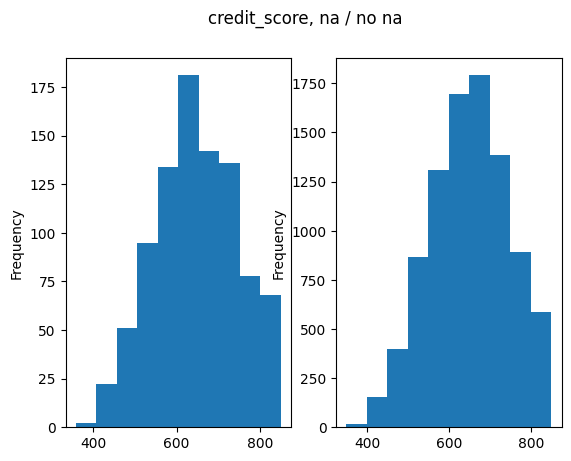

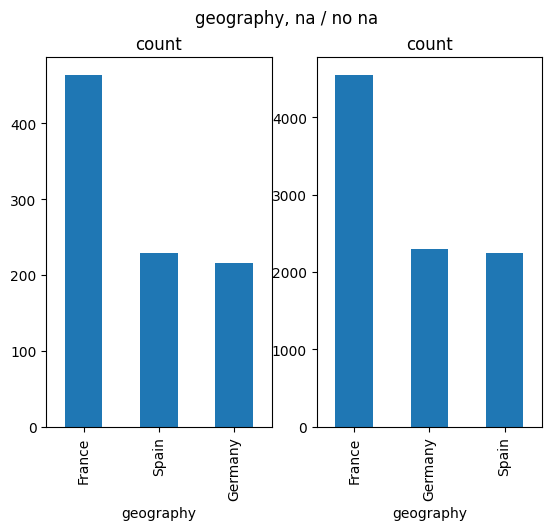

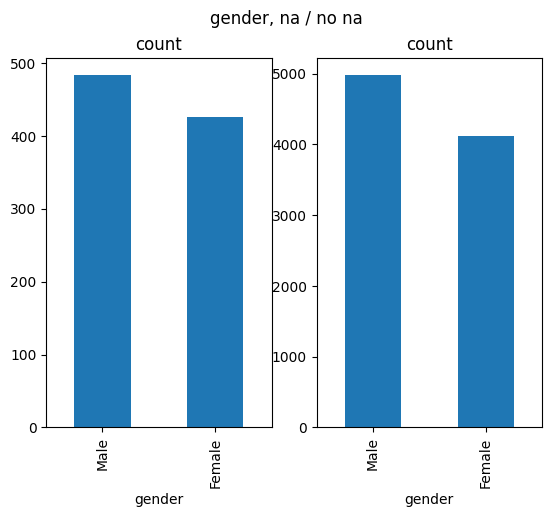

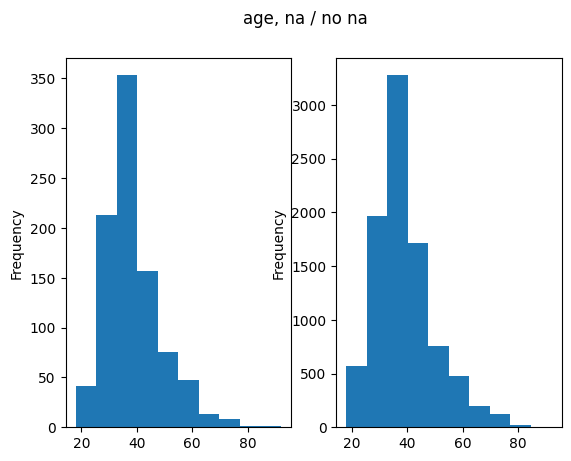

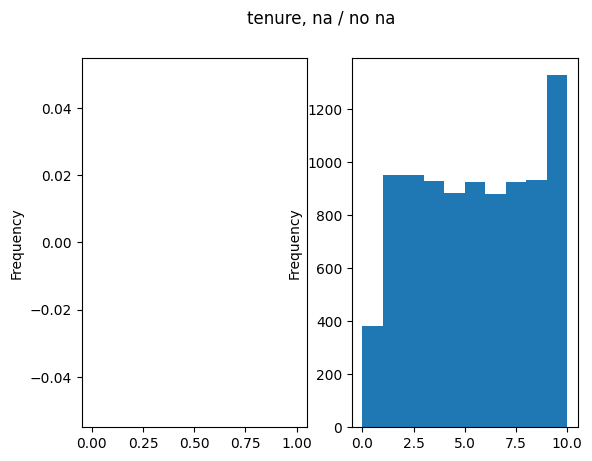

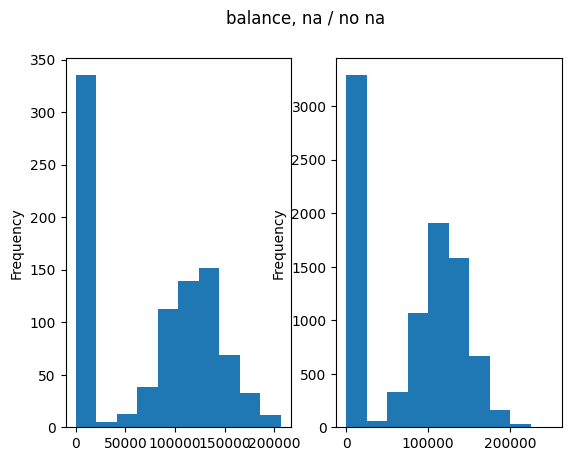

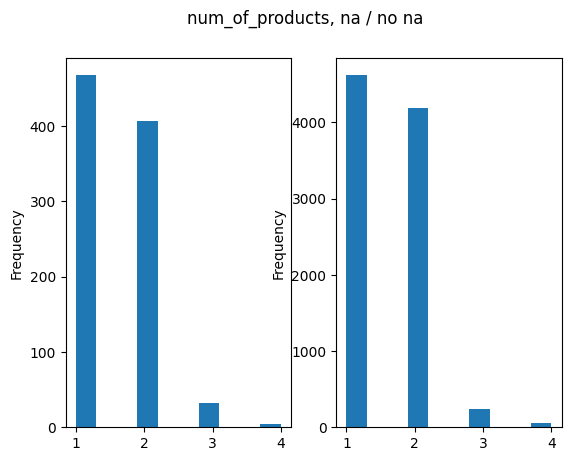

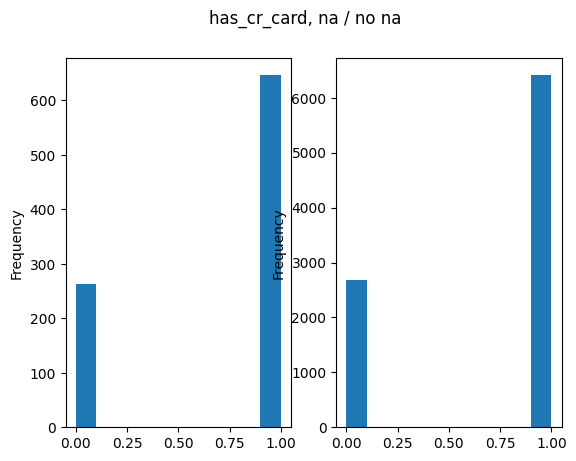

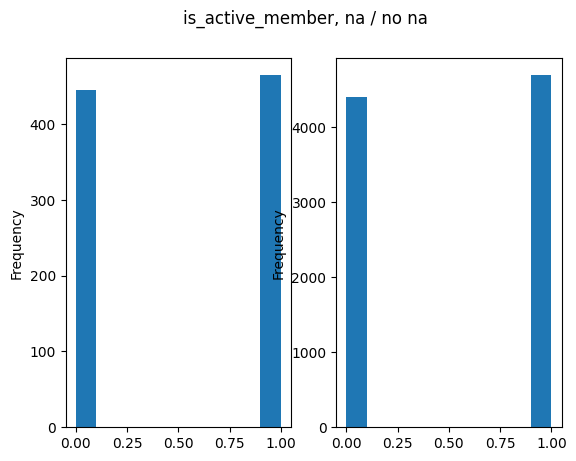

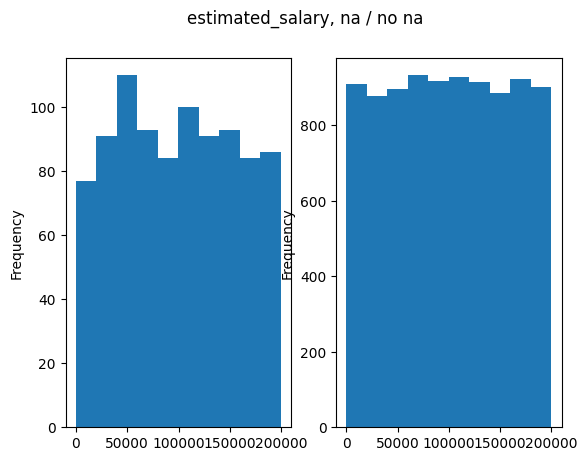

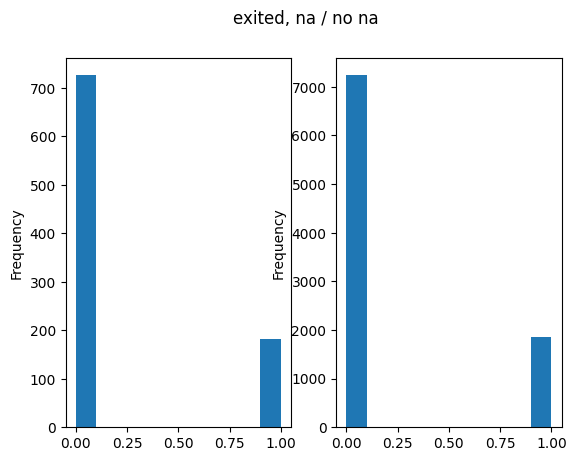

In [4]:
# for each column, compare values with and without gaps
def check_na(df, na_column):
    for column in df.columns:
        if data[column].dtypes == 'object' or 'id' in column:
            fig, axs = plt.subplots(nrows=1,ncols=2)
            df[df[na_column].isna()][column].value_counts().head(7).plot(kind='bar',title=f'{column}, na / no na',subplots=True, ax=axs[0])
            df[~df[na_column].isna()][column].value_counts().head(7).plot(kind='bar',subplots=True, ax=axs[1])
            plt.show()
        else:
            fig, axs = plt.subplots(nrows=1,ncols=2)
            df[df[na_column].isna()][column].plot(kind='hist',bins=10,title=f'{column}, na / no na',subplots=True, ax=axs[0])
            df[~df[na_column].isna()][column].plot(kind='hist',bins=10,subplots=True, ax=axs[1])
            plt.show()
check_na(data,'tenure')

The ratios of the values of different columns are very similar, there are no outliers. Most importantly, the ratio of the target feature is the same.

In [5]:
print('exited na / exited no na')
data[data['tenure'].isna()].exited.mean() / data[~data['tenure'].isna()].exited.mean()

exited na / exited no na


0.9871636030917007

To build an accurate model, we need as much accurate data as possible. Let's discard incomplete rows, this is approximately 10% of the data.

In [6]:
data = data.dropna().reset_index(drop=True)

## Model creation and testing

In [7]:
data.exited.mean()

0.2039379606203938

Churn ~ 1/5 of all clients

Let's convert categorical values to numerical values by direct coding

In [8]:
data = pd.get_dummies(data, drop_first=True)
features, target = data.drop(['exited'], axis=1), data['exited']

### Sampling

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=state)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=state)

### Feature scaling

In [10]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid) 
features_test = scaler.transform(features_test) 

set_min_est = 10
set_max_est = 51
set_min_depth = 4
set_max_depth = 13

# adding results for various models in one dataframe
def get_result(models,features_train, features_valid, target_train, target_valid, model_name):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid,predictions_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    new_model = pd.DataFrame({'f1_score':[f1],
                          'max_depth': [depth],
                          'n_estimators': [est],
                          'auc_roc': [auc_roc],
                          'model': [model_name]})
    models = pd.concat([models, new_model], ignore_index=True)
    return models

Let's create 3 types of models and compare them using the F1-measure.

### DecisionTreeClassifier

In [11]:
model_name = 'DecisionTreeClassifier'
models = pd.DataFrame()
est = None
for depth in range(set_min_depth,set_max_depth):
    model = DecisionTreeClassifier(random_state=state, max_depth=depth)
    models = get_result(models,features_train, features_valid, target_train, target_valid, model_name)
print('DecisionTreeClassifier')
models = models.drop('n_estimators', axis=1).sort_values(by=['f1_score'],ascending=False).head().reset_index(drop=True)
display(models)
f1_1 = models.head(1)

DecisionTreeClassifier


,f1_score,max_depth,auc_roc,model
0,0.548701,7,0.816166,DecisionTreeClassifier
1,0.531447,9,0.781274,DecisionTreeClassifier
2,0.523256,11,0.726296,DecisionTreeClassifier
3,0.522613,5,0.825486,DecisionTreeClassifier
4,0.509246,12,0.702822,DecisionTreeClassifier


### RandomForestClassifier

RandomForestClassifier


,f1_score,max_depth,n_estimators,auc_roc,model
0,0.559068,12,30,0.844585,RandomForestClassifier
1,0.553691,10,30,0.853300,RandomForestClassifier
2,0.553542,10,20,0.850883,RandomForestClassifier
3,0.553120,11,50,0.848613,RandomForestClassifier
4,0.552980,12,40,0.842871,RandomForestClassifier


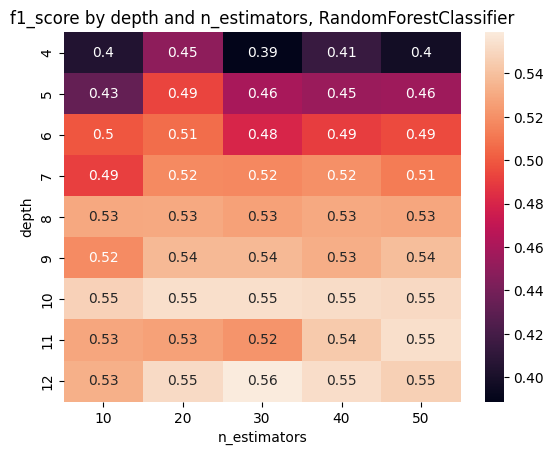

In [12]:
model_name = 'RandomForestClassifier'
models = pd.DataFrame()
for est in range(set_min_est, set_max_est, 10):
    for depth in range(set_min_depth,set_max_depth):
        model = RandomForestClassifier(random_state=state, max_depth=depth, n_estimators=est)
        models = get_result(models,features_train, features_valid, target_train, target_valid, model_name)
print('RandomForestClassifier')
(
sns.heatmap(models.pivot(index='max_depth', columns='n_estimators', values='f1_score'), annot=True)
   .set(title='f1_score by depth and n_estimators, RandomForestClassifier',
        xlabel='n_estimators', 
        ylabel='depth')
)
models = models.sort_values(by=['f1_score'],ascending=False).head().reset_index(drop=True)
display(models)
f1_2 = models.head(1)

### LogisticRegression

In [13]:
model_name = 'LogisticRegression'
models = pd.DataFrame()
model = LogisticRegression(random_state=state)
models = get_result(models,features_train, features_valid, target_train, target_valid, model_name)
models = models[['f1_score', 'auc_roc', 'model']]
display(models)
f1_3 = models.head(1)

,f1_score,auc_roc,model
0,0.293542,0.767227,LogisticRegression


### Results table

In [15]:
pd.concat([f1_1, f1_2, f1_3], ignore_index=True).sort_values(by=['f1_score'],ascending=False)

,f1_score,max_depth,auc_roc,model,n_estimators
1,0.559068,12.0,0.844585,RandomForestClassifier,30.0
0,0.548701,7.0,0.816166,DecisionTreeClassifier,NaN
2,0.293542,NaN,0.767227,LogisticRegression,NaN


RandomForestClassifier showed the highest F1-score and AUC-ROC value

## Correcting class disbalance
We'll try 3 balancing methods: class_weight, upsampling, downsampling.
### class_weight

,f1_score,max_depth,n_estimators,auc_roc,model
0,0.616601,10,30,0.851631,RandomForestClassifier
1,0.613037,11,30,0.842958,RandomForestClassifier
2,0.610966,10,20,0.850582,RandomForestClassifier
3,0.608696,10,40,0.851605,RandomForestClassifier
4,0.606742,11,50,0.845429,RandomForestClassifier


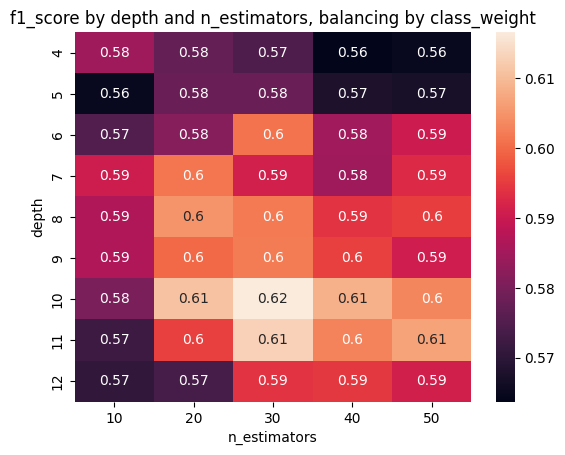

In [27]:
model_name = 'RandomForestClassifier'
models = pd.DataFrame()
for est in range(set_min_est, set_max_est, 10):
    for depth in range(set_min_depth,set_max_depth):
        model = RandomForestClassifier(random_state=state, max_depth=depth, n_estimators=est,class_weight='balanced')
        models = get_result(models,features_train, features_valid, target_train, target_valid, model_name)
best_model_class_weight = models.sort_values(by=['f1_score'],ascending=False).head().reset_index(drop=True)
display(best_model_class_weight)
best_model_class_weight['balancer'] = 'class_weight'
best_model_class_weight = best_model_class_weight.head(1)
(
sns.heatmap(models.pivot(index='max_depth', columns='n_estimators', values='f1_score'), annot=True)
   .set(title='f1_score by depth and n_estimators, balancing by class_weight',
        xlabel='n_estimators', 
        ylabel='depth')
);

### Upsample

In [28]:
def upsample(features, target):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    repeat = round(len(features_zeros) / len(features_ones))
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=state)
    
    return features_upsampled, target_upsampled

features_train_upsample, target_train_upsample = upsample(features_train, target_train)

,f1_score,max_depth,n_estimators,auc_roc,model
0,0.610849,10,40,0.851991,RandomForestClassifier
1,0.610526,10,30,0.851963,RandomForestClassifier
2,0.608485,11,30,0.843593,RandomForestClassifier
3,0.605923,9,50,0.848841,RandomForestClassifier
4,0.604828,12,50,0.842080,RandomForestClassifier


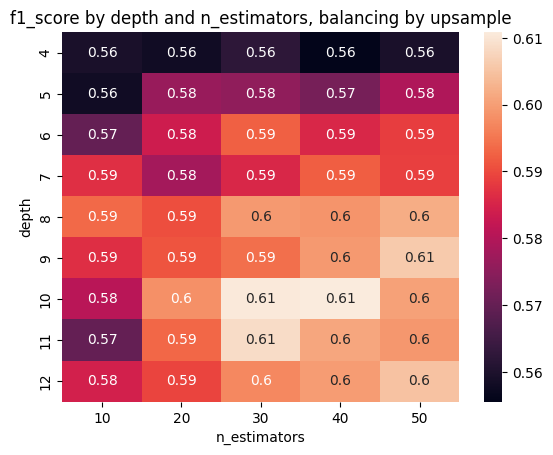

In [29]:
models = pd.DataFrame()
for est in range(set_min_est, set_max_est, 10):
    for depth in range(set_min_depth,set_max_depth):
        model = RandomForestClassifier(random_state=state, max_depth=depth, n_estimators=est)
        models = get_result(models,features_train_upsample, features_valid, target_train_upsample, target_valid, model_name)
best_model_upsample = models.sort_values(by=['f1_score'],ascending=False).head().reset_index(drop=True)
display(best_model_upsample)
best_model_upsample['balancer'] = 'upsample'
best_model_upsample = best_model_upsample.head(1)
(
sns.heatmap(models.pivot(index='max_depth', columns='n_estimators', values='f1_score'), annot=True)
   .set(title='f1_score by depth and n_estimators, balancing by upsample',
        xlabel='n_estimators', 
        ylabel='depth')
);

### Downsample

In [30]:
def downsample(features, target):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    fraction = len(features_ones) / len(features_zeros)

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=state)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=state)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=state)
    
    return features_downsampled, target_downsampled

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train)

,f1_score,max_depth,n_estimators,auc_roc,model
0,0.590031,12,30,0.840643,RandomForestClassifier
1,0.587137,8,50,0.848908,RandomForestClassifier
2,0.586864,6,50,0.847700,RandomForestClassifier
3,0.584200,9,30,0.845226,RandomForestClassifier
4,0.582979,4,40,0.833102,RandomForestClassifier


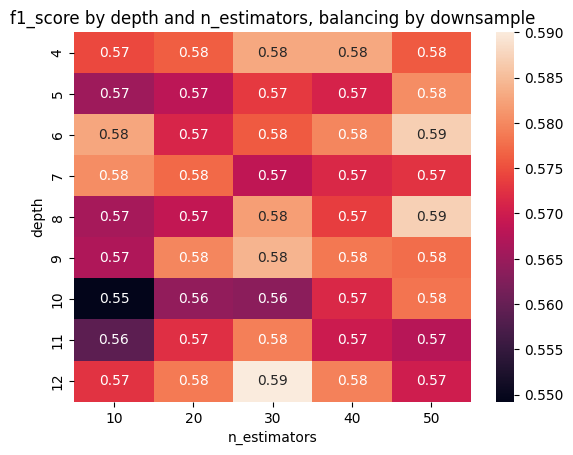

In [31]:
models = pd.DataFrame()
for est in range(set_min_est, set_max_est, 10):
    for depth in range(set_min_depth,set_max_depth):
        model = RandomForestClassifier(random_state=state, max_depth=depth, n_estimators=est)
        models = get_result(models,features_train_downsampled, features_valid, target_train_downsampled, target_valid, model_name)
best_model_downsample = models.sort_values(by=['f1_score'],ascending=False).head().reset_index(drop=True)
display(best_model_downsample)
best_model_downsample['balancer'] = 'downsample'
best_model_downsample = best_model_downsample.head(1)
(
sns.heatmap(models.pivot(index='max_depth', columns='n_estimators', values='f1_score'), annot=True)
   .set(title='f1_score by depth and n_estimators, balancing by downsample',
        xlabel='n_estimators', 
        ylabel='depth')
);

### Results table

In [32]:
best_models = pd.concat([best_model_class_weight] + [best_model_upsample] + [best_model_downsample])
best_models.sort_values(by=['f1_score'],ascending=False).reset_index(drop=True)

,f1_score,max_depth,n_estimators,auc_roc,model,balancer
0,0.616601,10,30,0.851631,RandomForestClassifier,class_weight
1,0.610849,10,40,0.851991,RandomForestClassifier,upsample
2,0.590031,12,30,0.840643,RandomForestClassifier,downsample


Each balancing method increased the F1-measure; the best balancing method was class_weight.
## Model testing
### Sanity test

In [36]:
worst_model_st = DummyClassifier(strategy='stratified',random_state=state)
worst_model_st.fit(features_train, target_train)
predictions_valid = worst_model_st.predict(features_valid)
dummy = accuracy_score(target_valid,predictions_valid)

worst_model_mf = DummyClassifier(strategy='most_frequent',random_state=state)
worst_model_mf.fit(features_train, target_train)
predictions_valid = worst_model_mf.predict(features_valid)
print('Accuracy of DummyClassifier:',accuracy_score(target_valid,predictions_valid))

best_model = RandomForestClassifier(random_state=state,
                               max_depth=best_model_class_weight.max_depth[0],
                               n_estimators=best_model_class_weight.n_estimators[0].astype('int'),
                               class_weight='balanced')
best_model.fit(features_train, target_train)
predictions_valid = best_model.predict(features_valid)
bummy = accuracy_score(target_valid,predictions_valid)
print('Accuracy of RandomForestClassifier:', accuracy_score(target_valid,predictions_valid))

Accuracy of DummyClassifier: 0.7872457394172623
Accuracy of RandomForestClassifier: 0.840021990104453


Model is adequate. Next, F1-measure with a test sample.

In [37]:
predictions_test = best_model.predict(features_test)
result = f1_score(target_test,predictions_test)
print('f1_score test:',result)
print('f1_score valid:',best_model_class_weight.f1_score[0])

f1_score test: 0.6204986149584487
f1_score valid: 0.616600790513834


Test sample is consistent with validation sample, F1-measure is higher than 0.59

Finally, building ROC curve and measuring AUC-ROC for test sample

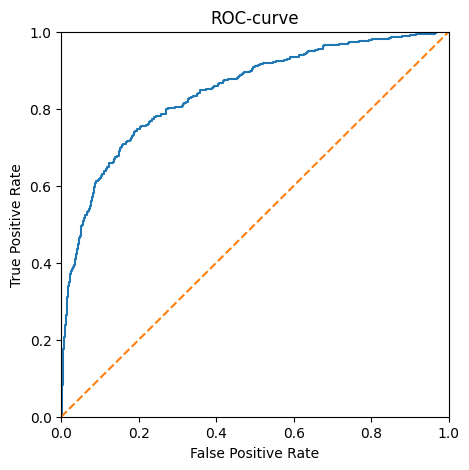

AUC-ROC value


0.8449213827915354

In [38]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()
print('AUC-ROC value')
roc_auc_score(target_test,probabilities_one_test)

## General conclusion

In [39]:
print('Accuracy best/nul model:', '%.2f' % (bummy / dummy))
best_predicted_valid = best_model.predict(features_valid)
worst_predicted_valid = worst_model_st.predict(features_valid)
print('Recall best/nul model:','%.2f' % (recall_score(target_valid, best_predicted_valid)/
                                                    recall_score(target_valid, worst_predicted_valid)))
print('Recall best model:','%.2f' % recall_score(target_valid, best_predicted_valid))

Accuracy best/nul model: 1.25
Recall best/nul model: 2.92
Recall best model: 0.60


The resulting model averages 25% more correct answers and 3 times more recall than a null model and can be used to make more informed churn predictions.

Let's consider the relative influence of factors

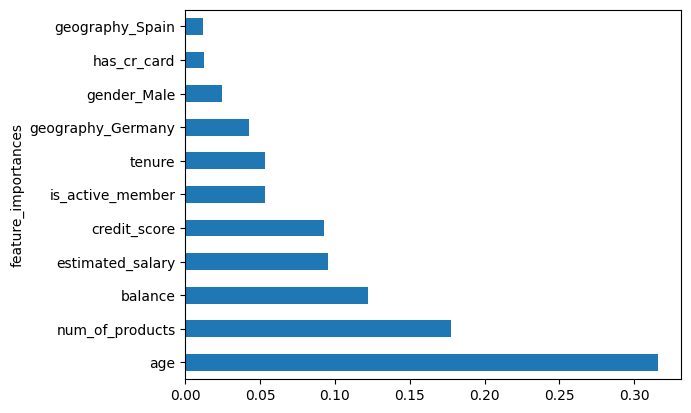

In [42]:
(
pd.Series(best_model.feature_importances_, index=features.columns)
    .sort_values(ascending=False)
    .plot.barh(ylabel="feature_importances")
);